# Topic Modeling


Over the years, different methods have been developed in the area of Natural Language Processsing to get insights through texts - from words to sentences to paragraphs to documents. At the document level, a useful ways to understanding the text is by analysing its topics. Topic Modelling is the process of learning, recognising and extracting the topics across a collection of documents. 

The idea is that each document in the corpus is made up of one or more than one topic and each topic is built from a bag of words. 

This notebook covers one of the most popular technique of Topic Modelling, **Latent Dirichlet Allocation**. This method was specifically designed for text data. However, it has a wide variety of usecases due to its popularity. One of the most popular use cases of LDA out of text analytics is face recognition where image is the data. 

## Library Imports

In [2]:
# Import Os to get to the root directory
import os
import sys

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

# Import own functions
from libraries import corpus
from libraries import pdf2text
import spacy
import en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable =['parser', 'ner'])
import re, numpy as np, pandas as pd
from pprint import pprint

#gensim
import gensim
import gensim, spacy, logging, warnings
from gensim import corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
%matplotlib inline

#nltk
import nltk as nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
from nltk.stem.wordnet import WordNetLemmatizer
import string

#other imports
import warnings
from importlib import reload
warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

## Data Preprocessing

In [3]:
#import dataset
reload(corpus)

<module 'libraries.corpus' from 'C:\\Users\\sj\\Documents\\GitHub\\datascience_project\\libraries\\corpus.py'>

In [4]:
dataset = pdf2text.get_dataset()

2019-06-26 07:21:30,627 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...
2019-06-26 07:21:30,627 : WARNING : Failed to see startup log message; retrying...


In [5]:
dataset.keys()

dict_keys(['#metahash', '0x', 'abbccoin', 'aion', 'apollocurrency', 'ardor', 'ark', 'basicattentiontoken', 'bhpcoin', 'binancecoin', 'bitcoin', 'bitcoingold', 'bitshares', 'bittorrent', 'bytecoin', 'bytom', 'celernetwork', 'chainlink', 'cosmocoin', 'cosmos', 'crypto', 'cryptonex', 'dai', 'dash', 'decentraland', 'dent', 'digixdao', 'dogecoin', 'elastos', 'enjincoin', 'eos', 'ethereum', 'ethereumclassic', 'factom', 'fantom', 'gnosis', 'golem', 'gxchain', 'holo', 'horizen', 'hypercash', 'hyperion', 'icon', 'iexecrlc', 'inocoin', 'iota', 'japancontenttoken', 'komodo', 'latoken', 'lina', 'loopring', 'maidsafecoin', 'maker', 'metal', 'metaverseetp', 'mixin', 'monero', 'nano', 'nebulas', 'nem', 'nexo', 'nkn', 'obyte', 'omisego', 'ontology', 'orbs', 'particl', 'paxosstandardtoken', 'powerledger', 'pundix', 'ravencoin', 'riftoken', 'siacoin', 'singularitynet', 'skycoin', 'solve', 'status', 'steem', 'stellar', 'stratis', 'synthetixnetworktoken', 'tenx', 'tether', 'tezos', 'theta', 'thetafuel', '

In [6]:
corpora = corpus.makeCleanCorpus(dataset, lemmatize=False, removePunct=True, removeNums=True,makeSentences=True, removeURL=True)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading en_core_web_md: Package 'en_core_web_md' not
[nltk_data]     found in index


Cleaning: #metahash
Cleaning: 0x
Cleaning: abbccoin
Cleaning: aion
Cleaning: apollocurrency
Cleaning: ardor
Cleaning: ark
Cleaning: basicattentiontoken
Cleaning: bhpcoin
Cleaning: binancecoin
Cleaning: bitcoin
Cleaning: bitcoingold
Cleaning: bitshares
Cleaning: bittorrent
Cleaning: bytecoin
Cleaning: bytom
Cleaning: celernetwork
Cleaning: chainlink
Cleaning: cosmocoin
Cleaning: cosmos
Cleaning: crypto
Cleaning: cryptonex
Cleaning: dai
Cleaning: dash
Cleaning: decentraland
Cleaning: dent
Cleaning: digixdao
Cleaning: dogecoin
Cleaning: elastos
Cleaning: enjincoin
Cleaning: eos
Cleaning: ethereum
Cleaning: ethereumclassic
Cleaning: factom
Cleaning: fantom
Cleaning: gnosis
Cleaning: golem
Cleaning: gxchain
Cleaning: holo
Cleaning: horizen
Cleaning: hypercash
Cleaning: hyperion
Cleaning: icon
Cleaning: iexecrlc
Cleaning: inocoin
Cleaning: iota
Cleaning: japancontenttoken
Cleaning: komodo
Cleaning: latoken
Cleaning: lina
Cleaning: loopring
Cleaning: maidsafecoin
Cleaning: maker
Cleaning: met

In [7]:
corpora['xrp'][:5]

['ripple protocol consensus algorithm davidripplecom nyoungsnyuedu arthurripplecom sever consensus gorithms exist specificly pertains distributed payment systems many suffer high latency induced requirement nodes within nerk communicate synchronously ',
 'work present novel consensus gorithm circumvents requirement utilizing collectivelytrusted subnerks within larger nerk ',
 'show trust required subnerks fact minim reduced principled choice member nodes ',
 'addition show minim connectivity required maintain agreement throughout whole nerk ',
 'result lowlatency consensus gorithm still maintains robustness face failures ']

In [8]:
#Our dictionary at the moment is in key: blockchain firms, value: list of text of whitepapers
#We change this to key: blockchain firms and value: string format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

In [9]:
#Combining then
data_combined = {key:[combine_text(value)] for (key, value) in corpora.items()}

In [10]:
#Putting the text into pandas dataframe
import pandas as pd
pd.set_option('max_colwidth', 150)

data_df = pd.DataFrame.from_dict(data_combined).transpose()
data_df.columns = ['whitepapers']
data_df = data_df.sort_index()

In [11]:
#Glancing into xrp Whitepaper
data_df.whitepapers.loc['xrp']

'ripple protocol consensus algorithm davidripplecom nyoungsnyuedu arthurripplecom sever consensus gorithms exist specificly pertains distributed payment systems many suffer high latency induced requirement nodes within nerk communicate synchronously  work present novel consensus gorithm circumvents requirement utilizing collectivelytrusted subnerks within larger nerk  show trust required subnerks fact minim reduced principled choice member nodes  addition show minim connectivity required maintain agreement throughout whole nerk  result lowlatency consensus gorithm still maintains robustness face failures  present gorithm embodiment  contents introduction definitions formization previous work  formization  existing consensus algorithms  form consensus gos  ripple consensus algorithm  definition  correctness  agreement  utility  convergence heuristics edures simulation code discussion acknowledgments references  introduction interest research distributed consensus systems increased marke

In [12]:
#Pickling the data for future use. 
import pickle
#data_df.to_pickle('tmcorpus.pkl')

In [13]:
with open('tmcorpus.pkl', 'rb') as f:
    data_df = pickle.load(f)

### Document-Term Matrix

Since the goal of this notebook is Topic Modelling, the text must be tokenized which means broken down to small pieces which here is words. We use scikit-learn's CountVectorizer technique where every row represents a different document and every column will represent a different word. 

At this moment, stop words are also removed thanks to CountVectorizer. Stop words are common words that seldom adds meaning or value to the text. 


In [14]:
#Creating a document-term matrix using CountVectorizer, and removing common english stop words. 

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words ='english')
data_cv = cv.fit_transform(data_df.whitepapers)
data_dtm = pd.DataFrame(data_cv.toarray(), columns = cv.get_feature_names())
data_dtm.index = data_df.index
data_dtm

,aaab,aaafdfddddcaf,aack,aacks,aadbcfeedccfbdcfdca,aaddrask,aael,aagree,aagreeesk,aagreeivk,...,ztestsapling,zverify,zverifyingey,zverifyrt,zverifyvkx,zviews,zviewtestsapling,zxqzwpqhdnfwaxhuklhksirdwathdm,zxxxxxxxxxxxx,zygomys
#metahash,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abbccoin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aion,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
apollocurrency,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ardor,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ark,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
basicattentiontoken,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bhpcoin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
binancecoin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#pickling the document-term matrix
data_dtm.to_pickle('dtm.pkl')

In [16]:
#importing necessary modules for LDA and gensim
from gensim import matutils, models
import scipy.sparse
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level = logging.INFO)

In [17]:
#importing the term-document matrix and converting it into document-term matrix with transpose

tdm = data_dtm.transpose()
tdm.head(5)

,#metahash,0x,abbccoin,aion,apollocurrency,ardor,ark,basicattentiontoken,bhpcoin,binancecoin,...,usdcoin,utrust,vechain,waltonchain,wanchain,waves,wax,xrp,zcash,zilliqa
aaab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaafdfddddcaf,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
aack,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aacks,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aadbcfeedccfbdcfdca,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
#Converting the term-document matrix into gensim corpus format which follows a sequence from dataframe to sparse matrix to gensim corpus
sparse_docs = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_docs)

In [19]:
#Creating term dictionary of our corpus, where every unique term is assigned an index
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [20]:
#lda time!!!

lda = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
lda.print_topics()

[(0,
  '0.010*"blockchain" + 0.008*"data" + 0.007*"nerk" + 0.006*"platform" + 0.006*"technology" + 0.006*"users" + 0.006*"token" + 0.005*"smart" + 0.005*"development" + 0.005*"tokens"'),
 (1,
  '0.013*"nodes" + 0.012*"transaction" + 0.012*"block" + 0.009*"nerk" + 0.009*"node" + 0.008*"key" + 0.007*"consensus" + 0.007*"protocol" + 0.007*"transactions" + 0.005*"hash"'),
 (2,
  '0.022*"let" + 0.018*"ned" + 0.014*"bit" + 0.013*"note" + 0.012*"pend" + 0.010*"value" + 0.010*"commitment" + 0.009*"visited" + 0.009*"ote" + 0.009*"url"'),
 (3,
  '0.017*"tokens" + 0.011*"price" + 0.011*"token" + 0.010*"assets" + 0.009*"market" + 0.009*"value" + 0.007*"exchange" + 0.007*"crypto" + 0.007*"fiat" + 0.007*"cryptocurrency"'),
 (4,
  '0.011*"dent" + 0.009*"safecoin" + 0.007*"child" + 0.003*"supporters" + 0.003*"vault" + 0.002*"brief" + 0.002*"accountability" + 0.002*"talk" + 0.002*"telcos" + 0.002*"summary"')]

## Visualization / Outcome

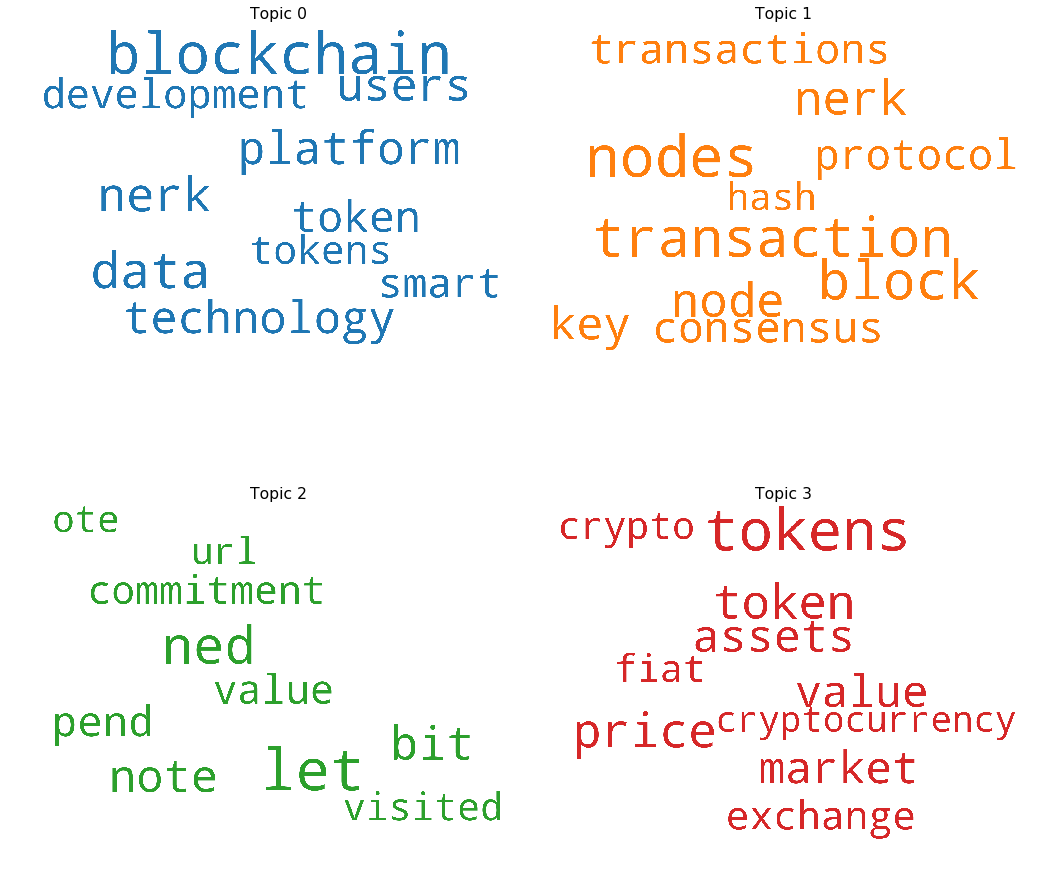

In [21]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True, dpi = 70)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

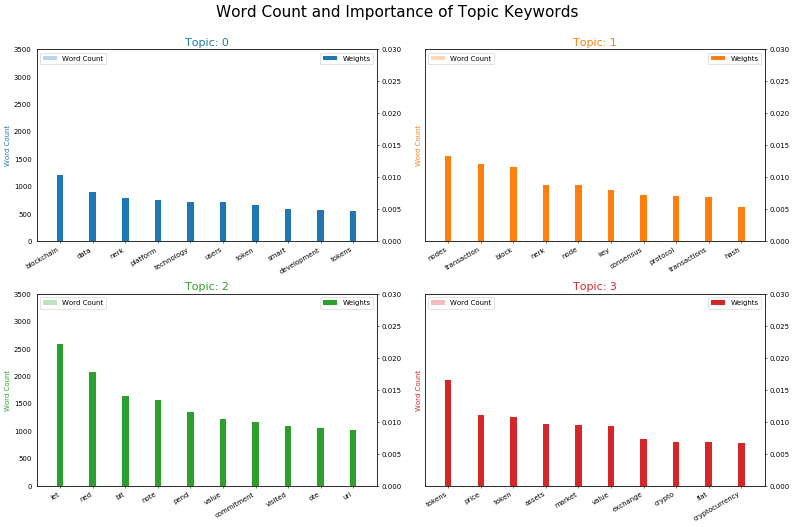

In [22]:
from collections import Counter
topics = lda.show_topics(formatted=False)
data_flat = [w for w_list in corpus for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=50)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [23]:
#Adding obvious words such as tokens, blockchain, node, transaction etc into stopwords 
from sklearn.feature_extraction import text
add_stop_words = ['tokens', 'token', 'blockchain', 'transactions', 'transaction', 'node', 'smart', 'public']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)


In [24]:
#creating a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [25]:
# Read in the cleaned data, before the CountVectorizer step
data_clean = pd.read_pickle('tmcorpus.pkl')

In [26]:
# Apply the nouns function to the whitepapers to filter only on nouns
data_nouns = pd.DataFrame(data_clean.whitepapers.apply(nouns))

In [27]:
#Adding more stopwords
from sklearn.feature_extraction import text
add_stop_words = ['tokens', 'token', 'blockchain', 'transactions', 'transaction', 'node', 'nodes', 'smart', 'public', 'price', 'payment', 'block', 'chain', 'users', 'user', 'data', 'exchange']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(data_nouns.whitepapers)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index
data_dtmn

,aaafdfddddcaf,aack,aacks,aaddrask,aagreesk,aal,aashoek,abandd,abbreviation,abbreviations,...,zprove,zprovepkxw,zprovingey,zsnar,zsolt,zverify,zverifyingey,zverifyrt,zverifyvkx,zxxxxxxxxxxxx
#metahash,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abbccoin,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
aion,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
apollocurrency,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ardor,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ark,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
basicattentiontoken,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bhpcoin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
binancecoin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [29]:
# Let's start with 2 topics
lda_2 = gensim.models.ldamodel.LdaModel(corpus=corpusn,
                                           id2word=id2wordn,
                                           num_topics=10, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
lda_2.print_topics()

[(0,
  '0.017*"state" + 0.012*"consensus" + 0.010*"blocks" + 0.008*"time" + 0.008*"protocol" + 0.008*"channel" + 0.007*"contract" + 0.007*"video" + 0.007*"number" + 0.006*"validators"'),
 (1,
  '0.018*"event" + 0.013*"consensus" + 0.012*"state" + 0.012*"blocks" + 0.010*"process" + 0.009*"time" + 0.009*"protocol" + 0.008*"root" + 0.008*"number" + 0.007*"account"'),
 (2,
  '0.024*"order" + 0.019*"protocol" + 0.015*"orders" + 0.013*"consensus" + 0.009*"agreement" + 0.009*"quorum" + 0.008*"value" + 0.008*"ballot" + 0.008*"intersection" + 0.008*"values"'),
 (3,
  '0.015*"platform" + 0.010*"business" + 0.008*"market" + 0.007*"child" + 0.007*"team" + 0.007*"information" + 0.007*"companies" + 0.006*"services" + 0.006*"applications" + 0.006*"customers"'),
 (4,
  '0.012*"time" + 0.009*"review" + 0.009*"attention" + 0.008*"signature" + 0.007*"information" + 0.007*"publishers" + 0.006*"platform" + 0.006*"key" + 0.006*"value" + 0.006*"market"'),
 (5,
  '0.009*"time" + 0.009*"technology" + 0.007*"de

In [30]:
# Compute Perplexity
print('\nPerplexity: ', lda_2.log_perplexity(corpusn))  # a measure of how good the model is. lower the better.


Perplexity:  -7.6350401380820765


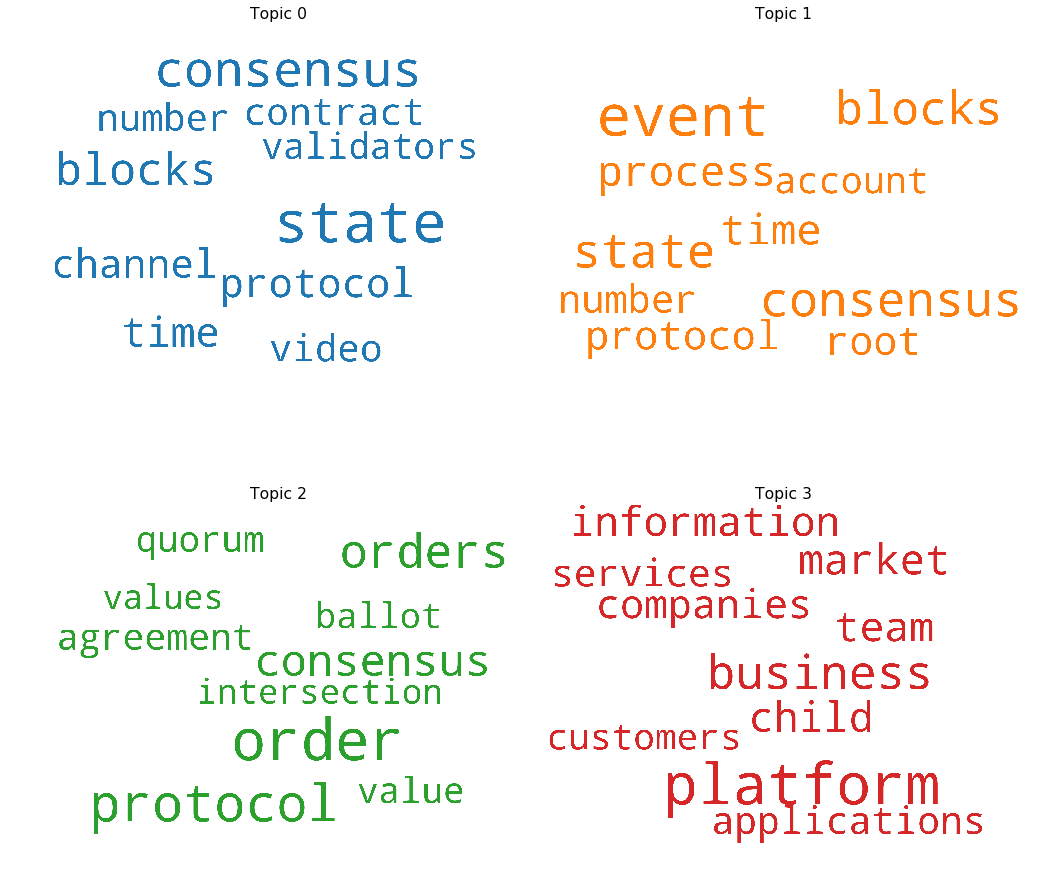

In [32]:
#Lets see how the top words differ
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_2.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True, dpi = 70)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Method Application

References:

https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

TopicModels_LDA Notebook from Prof. Markus Loecher